Adjust the boundaries according to Table 3, to get the desired optimal solutions.

C:\Users\spyro\AppData\Local\Temp\ipykernel_21964\3180873891.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\spyro\AppData\Local\Temp\ipykernel_21964\3180873891.py:49: RuntimeWarning: invalid value encountered in scalar multiply
  psi_value = (c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x3 / (sqrt(2*pi) * gamma(x3) * x3) *
C:\Users\spyro\AppData\Local\Temp\ipykernel_21964\3180873891.py:50: RuntimeWarning: invalid value encountered in scalar multiply
  K_half_plus * term1 - sign_x1 * c**(x3+0.5) * exp(sign_x1*c) * (1+u)**(1+x3) /
C:\Users\spyro\AppData\Local\Temp\ipykernel_21964\3180873891.py

Stopping search: Swarm best objective change less than 1e-08
Optimized Parameters:
theta: 0.07953815190699338
sigma: 0.13419871387406415
nu: 1.5022931911446724
r: 0.0


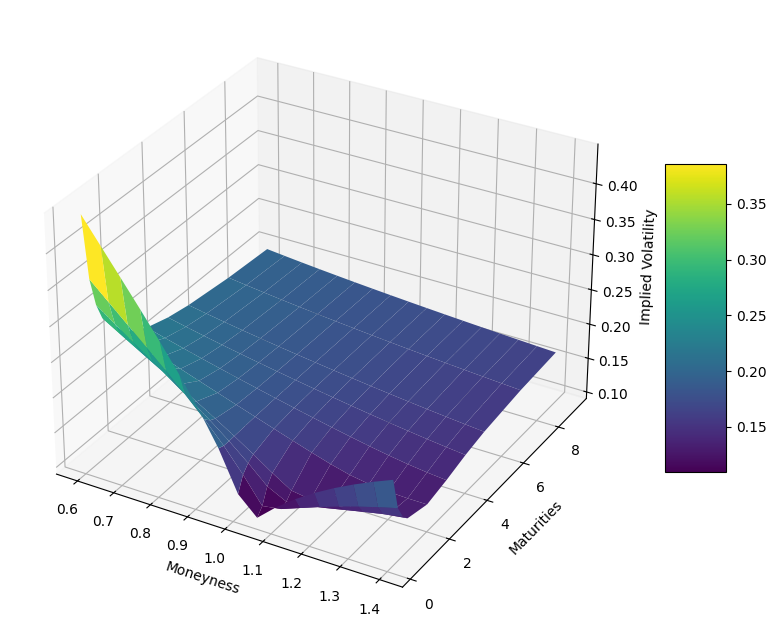

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.stats import norm
from scipy.special import kv, gamma
from math import exp, sqrt, pi, log, isfinite
from pyswarm import pso

# Load the data
file_path = r'file_path = r'/workspaces/VG-Equity-Modelling/target_all.xlsx'
df_raw = pd.read_excel(file_path, engine='openpyxl')

# Drop rows with NaN values
df = df_raw.dropna()

# Extract maturities and moneyness
maturities = np.array(df.iloc[:, 0])
moneyness = np.array(df.columns[1:], dtype=float)

# Extract IV_target
IV_target = np.array(df.iloc[:, 1:], dtype=float)

# Define the degenerate hypergeometric function
def degenerate_hypergeometric_function(y1, y2, y3, p1, p2):
    def integrand(x):
        try:
            return (x ** (y1 - 1) * (1 - x) ** (y3 - y1 - 1) *
                    (1 - p1 * x) ** (-y2) * exp(p2 * x))
        except (OverflowError, ValueError): # OverflowError:
            return np.inf
    result, error = quad(integrand, 0, 1)
    return (gamma(y3) / (gamma(y1) * gamma(y3 - y1))) * result

# Define Psi function
def Psi(x1, x2, x3):
    try:
        c = abs(x1) * sqrt(2 + x2**2)
        u = x2 / sqrt(2 + x2**2)
        sign_x1 = np.sign(x1)

        term1 = degenerate_hypergeometric_function(x3, 1-x3, 1+x3, (1+u)/2, -sign_x1*c*(1+u))
        term2 = degenerate_hypergeometric_function(1+x3, 1-x3, 2+x3, (1+u)/2, -sign_x1*c*(1+u))

        K_half_plus = kv(x3 + 0.5, c)
        K_half_minus = kv(x3 - 0.5, c)

        psi_value = (c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x3 / (sqrt(2*pi) * gamma(x3) * x3) *
                     K_half_plus * term1 - sign_x1 * c**(x3+0.5) * exp(sign_x1*c) * (1+u)**(1+x3) /
                     (sqrt(2*pi) * gamma(x3) * (1+x3)) * K_half_minus * term2 +
                     sign_x1 * c**(x3+0.5) * exp(sign_x1*c) * (1+u)**x3 /
                     (sqrt(2*pi) * gamma(x3) * x3) * K_half_minus * term1)
    except (OverflowError, ValueError): # OverflowError:
        psi_value = np.inf
    return psi_value

# Define the European call option price function
def european_call_option_price(S0, K, T, r, theta, sigma, nu):
    try:
        a = theta / sqrt(sigma**2 + nu * theta**2 / 2)
        s = sigma**2 / sqrt(sigma**2 + nu * theta**2 / 2)
        c1 = nu * (a + s)**2 / 2
        c2 = nu * a**2 / 2
        
        d = (log(S0/K) + r*T + (T/nu) * log((1-c1)/(1-c2))) / s
        
        call_price = (S0 * Psi(d * sqrt((1-c1)/nu), (a + s) * sqrt(nu/(1 - c1)), T/nu) -
                      K * exp(-r*T) * Psi(d * sqrt((1-c2)/nu), a * sqrt(nu/(1 - c2)), T/nu))
    except (OverflowError, ValueError):
        call_price = np.inf
    return call_price

# Fix S0
S0 = 5639.17

# Define RMSE function to minimize
def rmse(params):
    r, theta, sigma, nu = params
    if theta < 1/nu - sigma**2 / 2:
        error = 0
        count = 0
        for i, T in enumerate(maturities):
            for j, M in enumerate(moneyness):
                K = S0 / M
                market_price = european_call_option_price(S0, K, T, r, theta, sigma, nu)
                model_iv = implied_volatility(S0, K, T, r, market_price)
                target_iv = IV_target[i, j]
                if not np.isnan(model_iv) and not np.isnan(target_iv):
                    error += (model_iv - target_iv) ** 2
                    count += 1
        if count == 0:
            return 10000
        else:
            return np.sqrt(error / count)
    else:
        return 10000

# Define implied volatility calculation using Black-Scholes model
def implied_volatility(S0, K, T, r, observed_price):
    def iv_objective(sigma):
        return black_scholes_call(S0, K, T, r, sigma) - observed_price
    try:
        return brentq(iv_objective, 0.01, 2.0)  # Search between 1% and 200% volatility
    except ValueError:
        return np.nan  # Return NaN if no solution is found

# Define Black-Scholes call option price function
def black_scholes_call(S0, K, T, r, sigma):
    if T <= 0:
        return max(S0 - K, 0)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Define parameter bounds
lb = [0, -2, 0.01, 0.06]  # Lower bounds for r, theta, sigma, nu
ub = [0.21, 2, 0.4, 4]  # Upper bounds for r, theta, sigma, nu 

# Perform the optimization using Particle Swarm Optimization
opt_params, opt_value = pso(rmse, lb, ub) #, swarmsize=100, maxiter=200, minfunc=1e-8, minstep=1e-8

r_opt, theta_opt, sigma_opt, nu_opt = opt_params

print(f"Optimized Parameters:\ntheta: {theta_opt}\nsigma: {sigma_opt}\nnu: {nu_opt}\nr: {r_opt}")

# Calculate the implied volatility surface using the optimized parameters
implied_vols_opt = np.zeros((len(maturities), len(moneyness)))

for i, T in enumerate(maturities):
    for j, M in enumerate(moneyness):
        K = S0 / M
        market_price = european_call_option_price(S0, K, T, r_opt, theta_opt, sigma_opt, nu_opt)
        implied_vols_opt[i, j] = implied_volatility(S0, K, T, r_opt, market_price)

# Plotting the implied volatility surface with optimized parameters
X, Y = np.meshgrid(moneyness, maturities)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, implied_vols_opt, cmap='viridis')

# Add labels
ax.set_ylabel('Maturities')
ax.set_xlabel('Moneyness')
ax.set_zlabel('Implied Volatility')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()


In [2]:
print(np.round(opt_params, 6))

[0.       0.079538 0.134199 1.502293]


In [3]:
opt_value

0.01128025677719345